In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import rotate
from multiprocess import Pool

import pandas

Setting environment for Gordon


No vtk


In [2]:
from cell_utilities import *

In [3]:
stack = 'MD589'

In [4]:
sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
first_bs_section, last_bs_section = metadata_cache['section_limits'][stack]

In [6]:
DETECTED_CELLS_DIR = '/home/yuncong/csd395/CSHL_cells_v2/detected_cells/' + stack

In [7]:
# 1. Flatten all blobs from different sections into a single list
# 2. Load blob orientation -> horizontalize blobs -> mirror in three directions
# Load major axis length, minor axis length, put into single list

# Create variations of blobs
# Rotate cells so that major axis is horizontal.

cell_orientations = []
cell_majorAxisLens = []
cell_minorAxisLens = []
cell_addresses = []

cells_aligned = []
cells_aligned_h = []
cells_aligned_v = []
cells_aligned_d = []

# for sec in range(first_bs_section, last_bs_section, 50):

for sec in [192, 242]:

    fn = sections_to_filenames[sec]
    fn_output_dir = create_if_not_exists(os.path.join(DETECTED_CELLS_DIR, fn))

    sys.stderr.write('Processing section: %03d\n' % sec)
    
    t = time.time()
    
#     blob_coords = pandas.read_hdf(fn_output_dir + '/%(fn)s_blobCoords.hdf' % {'fn': fn}, 'data')
#     blob_coords = pickle.load(open(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_blobCoords.pkl' % {'fn': fn}, 'r'))
    
    blob_orientations = bp.unpack_ndarray_file(fn_output_dir + '/%(fn)s_blobOrientations.bp' % {'fn': fn})
    blob_majorAxisLens = bp.unpack_ndarray_file(fn_output_dir + '/%(fn)s_blobMajorAxisLen.bp' % {'fn': fn})
    blob_minorAxisLens = bp.unpack_ndarray_file(fn_output_dir + '/%(fn)s_blobMinorAxisLen.bp' % {'fn': fn})
    
    sys.stderr.write('Generate cell masks: %.2f\n' % (time.time() - t))

#     blob_centers = bp.unpack_ndarray_file(fn_output_dir + '/%(fn)s_blobCentroids.bp' % {'fn': fn})
#     blob_centers = [coords.mean(axis=0) for coords in blob_coords]

    blob_masks = pandas.read_hdf(fn_output_dir + '/%(fn)s_blobMasks.hdf' % {'fn': fn}, 'data')
    n_blobs = len(blob_masks)
    
    blob_mask_centers = bp.unpack_ndarray_file(fn_output_dir + '/%(fn)s_blobMaskCenters.bp' % {'fn': fn})
    
    bar = show_progress_bar(0, n_blobs-1)
    
    t = time.time()
    
    for i in range(n_blobs):
        
        bar.value = i
        
        patch_rotated = rotate(blob_masks[i], angle=-np.rad2deg(blob_orientations[i]), 
                               center=blob_mask_centers[i], 
                               cval=0.) > .5
        
        # horizontal mirrored
        patch_rotated_h = patch_rotated[:, ::-1].copy()
        
        # vertical mirrored
        patch_rotated_v = patch_rotated[::-1, :].copy()
        
        # diagonally mirrored
        patch_rotated_d = patch_rotated[::-1, ::-1].copy()

        cells_aligned.append(patch_rotated)
        cells_aligned_h.append(patch_rotated_h)
        cells_aligned_v.append(patch_rotated_v)
        cells_aligned_d.append(patch_rotated_d)
        
    sys.stderr.write('Generate cell masks: %.2f\n' % (time.time() - t))
        
#     cells_aligned = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned.bp' % {'fn': fn})
#     cells_aligned_h = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned_h.bp' % {'fn': fn})
#     cells_aligned_v = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned_v.bp' % {'fn': fn})
#     cells_aligned_d = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned_d.bp' % {'fn': fn})
     
    cell_orientations.append(blob_orientations)
    cell_majorAxisLens.append(blob_majorAxisLens)
    cell_minorAxisLens.append(blob_minorAxisLens)
    cell_addresses += [(sec, i) for i in range(n_blobs)]
    
cell_orientations = np.concatenate(cell_orientations)
cell_majorAxisLens = np.concatenate(cell_majorAxisLens)
cell_minorAxisLens = np.concatenate(cell_minorAxisLens)

Processing section: 192
Generate cell masks: 0.13
Generate cell masks: 111.42
Processing section: 242
Generate cell masks: 0.08
Generate cell masks: 97.58


In [11]:
# pickle.dump(cells_aligned, open(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned.bp' % {'fn': fn}, 'w'))
# pickle.dump(cells_aligned_h, open(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned_h.bp' % {'fn': fn}, 'w'))
# pickle.dump(cells_aligned_v, open(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned_v.bp' % {'fn': fn}, 'w'))
# pickle.dump(cells_aligned_d, open(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_cellsAligned_d.bp' % {'fn': fn}, 'w'))

In [8]:
# Place cell masks at the center and pad the surroundings with zeros.

output_dir = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/processed_cells')

cells_aligned_padded = np.asarray(pad_patches_to_same_size(cells_aligned, pad_value=0, keep_center=True))
bp.pack_ndarray_file(cells_aligned_padded, output_dir + '/cells_aligned_padded.bp')
del cells_aligned_padded

cells_h_aligned_padded = np.asarray(pad_patches_to_same_size(cells_aligned_h, pad_value=0, keep_center=True))
bp.pack_ndarray_file(cells_h_aligned_padded, output_dir + '/cells_h_aligned_padded.bp')
del cells_h_aligned_padded

cells_v_aligned_padded = np.asarray(pad_patches_to_same_size(cells_aligned_v, pad_value=0, keep_center=True))
bp.pack_ndarray_file(cells_v_aligned_padded, output_dir + '/cells_v_aligned_padded.bp')
del cells_v_aligned_padded

cells_d_aligned_padded = np.asarray(pad_patches_to_same_size(cells_aligned_d, pad_value=0, keep_center=True))
bp.pack_ndarray_file(cells_d_aligned_padded, output_dir + '/cells_d_aligned_padded.bp')
del cells_d_aligned_padded

In [9]:
bp.pack_ndarray_file(np.array(cell_addresses), output_dir + '/cell_addresses.bp')

In [ ]:
# Load processed cells

In [10]:
output_dir = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/processed_cells')

In [11]:
cell_addresses = bp.unpack_ndarray_file(output_dir + '/cell_addresses.bp')

cells_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_aligned_padded.bp')
cells_h_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_h_aligned_padded.bp')
cells_v_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_v_aligned_padded.bp')
cells_d_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_d_aligned_padded.bp')

In [12]:
n_cells = len(cells_aligned_padded)
print n_cells, 'cells'

# cells_aligned_padded_flattened = np.reshape(cells_aligned_padded, (n_cells, -1))
# cells_aligned_padded.shape

cell_sizes = np.reshape(cells_aligned_padded, (n_cells, -1)).sum(axis=1)

172998 cells


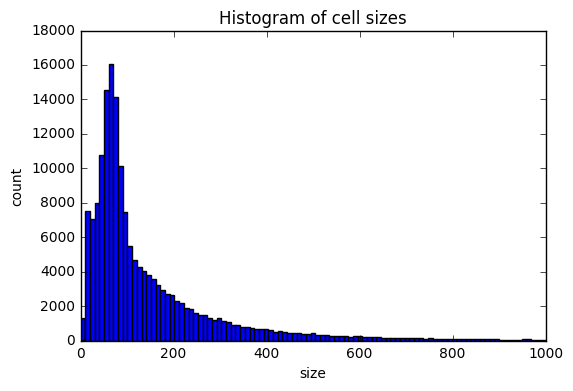

In [13]:
plt.hist(cell_sizes, bins=np.linspace(0, 1000, 100));
plt.title('Histogram of cell sizes');
plt.xlabel('size');
plt.ylabel('count');
plt.show();

In [51]:
# counts, edges = np.histogram(cell_sizes, bins=1000)
# counts = counts / float(n_cells)
# counts_cumsum = np.cumsum(counts)
# plt.plot(edges[:-1], counts_cumsum);
# plt.title('Cumulative');
# plt.xlabel('bins');
# plt.ylabel('percentage cumulatively covered');

# cutoff_percentage = .3 # 30% of the smallest cells will be below the threshold
# cell_size_threshold_small_medium = edges[np.where(counts_cumsum < cutoff_percentage)[0][-1]]
# plt.vlines(cell_size_threshold_small_medium, 0, 1, color='r');

# cutoff_percentage = .7
# cell_size_threshold_medium_large = edges[np.where(counts_cumsum < cutoff_percentage)[0][-1]]
# plt.vlines(cell_size_threshold_medium_large, 0, 1, color='r');
# plt.show();

In [ ]:
# Select only the top 30% large cells and do spectral embedding only for them.

In [14]:
cutoff_percentage_small_medium = .3
cutoff_percentage_medium_large = .7
c1 = int(cutoff_percentage_small_medium*n_cells)
c2 = int(cutoff_percentage_medium_large*n_cells)
indices_sorted_by_size = np.argsort(cell_sizes)
small_cell_indices = indices_sorted_by_size[:c1]
medium_cell_indices = indices_sorted_by_size[c1:c2]
large_cell_indices = indices_sorted_by_size[c2:]

n_small_cells = len(small_cell_indices)
n_medium_cells = len(medium_cell_indices)
n_large_cells = len(large_cell_indices)

print n_small_cells, n_medium_cells, n_large_cells

51899 69199 51900


In [15]:
selected_cell_indices = np.sort(large_cell_indices)
dataset_name = 'largest30p'

n_selected_cells = len(selected_cell_indices)

In [16]:
cells_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_aligned_padded.bp')
selected_cells_aligned_padded = cells_aligned_padded[selected_cell_indices].copy()
del cells_aligned_padded

In [17]:
cells_h_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_h_aligned_padded.bp')
selected_cells_h_aligned_padded = cells_h_aligned_padded[selected_cell_indices].copy()
del cells_h_aligned_padded

In [18]:
cells_v_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_v_aligned_padded.bp')
selected_cells_v_aligned_padded = cells_v_aligned_padded[selected_cell_indices].copy()
del cells_v_aligned_padded

In [19]:
cells_d_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_d_aligned_padded.bp')
selected_cells_d_aligned_padded = cells_d_aligned_padded[selected_cell_indices].copy()
del cells_d_aligned_padded

In [20]:
selected_cell_sizes = cell_sizes[selected_cell_indices]

In [ ]:
# nonsmall_cell_masks_normalized_flattened = cell_masks_normalized_flattened[nonsmall_cells_indices].copy()
# nonsmall_cell_masks_normalized_size = cell_masks_normalized_size[nonsmall_cells_indices].copy()
# print nonsmall_cell_masks_normalized_flattened.shape

In [ ]:
# Rescale all cells to the same size (optional)

In [ ]:
mean_size = int(nonsmall_cell_sizes.mean())
median_size = np.sort(nonsmall_cell_sizes)[len(nonsmall_cell_sizes)/2]
print mean_size, median_size

In [ ]:
def rescale_cell(i, mean_size):
    c = nonsmall_cells_aligned_padded[i]
    s = nonsmall_cell_sizes[i]
    rescaled = rescale(c, np.sqrt(float(mean_size)/s), cval=0) > .5
    xmin, xmax, ymin, ymax = bbox_2d(rescaled)
    rescaled_centered = rescaled[ymin:ymax+1, xmin:xmax+1].copy()
    return rescaled_centered

In [ ]:
t = time.time()

pool = Pool(16)
nonsmall_cells_aligned_rescaled = pool.map(lambda i: rescale_cell(i, mean_size), range(n_nonsmall_cells))
pool.terminate()
pool.join()

print time.time() - t # 24s / 60k cells

In [ ]:
nonsmall_cells_aligned_rescaled_padded = pad_patches_to_same_size(nonsmall_cells_aligned_rescaled, 
                                                         pad_value=0, keep_center=True)

In [ ]:
nonsmall_cells_padded_shape = nonsmall_cells_aligned_rescaled_padded[0].shape

In [ ]:
nonsmall_cells_aligned_rescaled_padded_flattened = np.reshape(nonsmall_cells_aligned_rescaled_padded, (n_nonsmall_cells, -1))
nonsmall_cell_rescaled_sizes = nonsmall_cells_aligned_rescaled_padded_flattened.sum(axis=1)

In [ ]:
bp.pack_ndarray_file(np.array(nonsmall_cells_aligned_rescaled_padded), output_dir + '/%(dataset_name)s_alignedRescaledPadded_cutoff%(cutoff)d.bp' % 
                     {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_small_medium*100})

bp.pack_ndarray_file(np.array(nonsmall_cell_rescaled_sizes), output_dir + '/%(dataset_name)s_rescaledSizes_cutoff%(cutoff)d.bp' % 
                     {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_small_medium*100})

bp.pack_ndarray_file(nonsmall_cells_indices, output_dir + '/%(dataset_name)s_indices_cutoff%(cutoff)d.bp' % 
                     {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_small_medium*100})

In [21]:
# bp.pack_ndarray_file(np.array(selected_cells_aligned_padded), output_dir + '/%(dataset_name)s_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# bp.pack_ndarray_file(np.array(selected_cells_h_aligned_padded), output_dir + '/%(dataset_name)s_h_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# bp.pack_ndarray_file(np.array(selected_cells_v_aligned_padded), output_dir + '/%(dataset_name)s_v_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# bp.pack_ndarray_file(np.array(selected_cells_d_aligned_padded), output_dir + '/%(dataset_name)s_d_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

bp.pack_ndarray_file(np.array(selected_cell_sizes), output_dir + '/%(dataset_name)s_sizes.bp' % 
                     {'dataset_name': dataset_name})

bp.pack_ndarray_file(selected_cell_indices, output_dir + '/%(dataset_name)s_indices.bp' % 
                     {'dataset_name': dataset_name})

In [29]:
from scipy.spatial.distance import squareform

In [30]:
selected_cell_arrays = selected_cells_aligned_padded.reshape((n_selected_cells, -1))
selected_cell_arrays_h = selected_cells_h_aligned_padded.reshape((n_selected_cells, -1))
selected_cell_arrays_v = selected_cells_v_aligned_padded.reshape((n_selected_cells, -1))
selected_cell_arrays_d = selected_cells_d_aligned_padded.reshape((n_selected_cells, -1))

In [39]:
set_selected_cell_arrays(selected_cell_arrays, 
                        selected_cell_arrays_h,
                        selected_cell_arrays_v,
                        selected_cell_arrays_d,
                        selected_cell_sizes)

In [40]:
def kmeans_plusplus(n_class):
    
    seeds = np.empty((n_class, ), np.int)

    distances_to_closest_seed = np.empty((n_selected_cells, ))
    indices_of_closest_seed = np.empty((n_selected_cells, ), np.int)

    t1 = time.time()

    bar = show_progress_bar(0, n_class)

    for it in range(n_class):

        bar.value = it

        if it == 0:
            seed = np.random.randint(n_selected_cells)
        else:
            seed = np.random.choice(range(n_selected_cells), 1, p=d2_weights)[0]

        seeds[it] = int(seed)

    #     t = time.time()
        distances = 1. - compute_jaccard_i_vs_all(seed)
    #     distances = 1. - compute_jaccard_with_i_parallel(seed)
    #     print time.time() - t
        # sequential: 0.05-0.5s / 20k cells
        # parallel: 0.35s, even slower than sequential


        if it == 0:
            distances_to_closest_seed = distances
            indices_of_closest_seed[:] = 0
        else:    
            needs_update = distances < distances_to_closest_seed
            distances_to_closest_seed[needs_update] = distances[needs_update]
            indices_of_closest_seed[needs_update] = it

        d2s = distances_to_closest_seed**2
        d2_weights = d2s / d2s.sum()

    sys.stderr.write('Kmeans++: %.2f seconds.\n' % (time.time() - t1)) # 164s / 1000 centers
    
    return seeds, indices_of_closest_seed

In [41]:
seeds, indices_of_closest_seed = kmeans_plusplus(n_class=100)

158.162632942


In [42]:
bp.pack_ndarray_file(seeds, output_dir + '/%(dataset_name)s_kmeansppCenters.bp' % {'dataset_name': dataset_name})

bp.pack_ndarray_file(indices_of_closest_seed, output_dir + '/%(dataset_name)s_closestKmeansppCenters.bp' % \
                     {'dataset_name': dataset_name})

# bp.pack_ndarray_file(memberCount, output_dir + '/%(dataset_name)s_indices_cutoff%(cutoff)d_kmeansppCentersMemberCount.bp' % \
#                     {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

In [36]:
# Load Kmeans++ results

In [43]:
seeds = bp.unpack_ndarray_file(output_dir + '/%(dataset_name)s_kmeansppCenters.bp' % \
                               {'dataset_name': dataset_name})

indices_of_closest_seed = bp.unpack_ndarray_file(output_dir + '/%(dataset_name)s_closestKmeansppCenters.bp' % \
                                                 {'dataset_name': dataset_name})

print len(seeds), 'kmeans++ centers'

100 kmeans++ centers


In [44]:
memberCount = np.bincount(indices_of_closest_seed, minlength=len(seeds))
seedIndices_sorted_by_memberCount = np.argsort(memberCount)[::-1]
memberCount_sorted = memberCount[seedIndices_sorted_by_memberCount]
seeds_ranked_by_memberCount = seeds[seedIndices_sorted_by_memberCount]

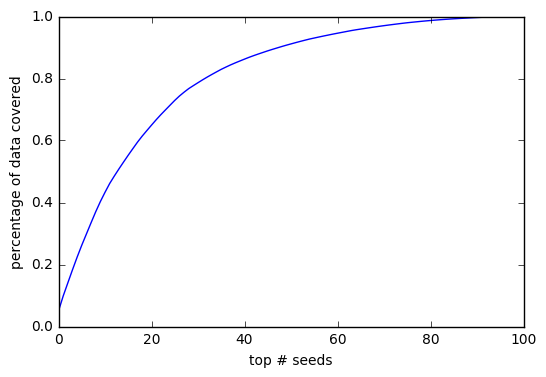

In [45]:
plt.plot(np.cumsum(memberCount_sorted) / float(n_selected_cells));
plt.xlabel('top # seeds');
plt.ylabel('percentage of data covered');

In [46]:
def compute_embedding(sample_indices):
    
    n_samples = len(sample_indices)
    
    t = time.time()

    affinities_with_samples = compute_jaccard_list_vs_all(sample_indices)

    sys.stderr.write('Compute pairwise affinities (with samples): %f s.\n' % (time.time()-t)) # 10 s / 200
    
    nonsample_indices = np.setdiff1d(range(affinities_with_samples.shape[1]), sample_indices)
    permutation = np.r_[sample_indices, nonsample_indices]

    ########################

    t = time.time()

    from scipy.linalg import sqrtm

    A = affinities_with_samples[:, sample_indices].copy()
    B = affinities_with_samples[:, nonsample_indices].copy()

    d1 = np.sum(np.c_[A, B], axis=1)
    Ai = np.linalg.inv(A)
    d2 = np.sum(B, axis=0) + np.dot(B.T, np.dot(Ai, np.sum(B, axis=1)))
    dhat_si = np.sqrt(1./np.r_[d1, d2])
    A = A*np.outer(dhat_si[:n_samples], dhat_si[:n_samples])
    B = B*np.outer(dhat_si[:n_samples], dhat_si[n_samples:])

    if any(np.linalg.eigvals(A) < 0):
        # A is indefinite
        print 'A is indefinite'

        U, L, UT = np.linalg.svd(A)

        Ubar = np.c_[U.T, np.dot(np.dot(np.linalg.inv(np.diag(L)), U.T), B)]
        Z = np.dot(Ubar.T, np.diag(np.sqrt(L)))
        F, S, FT = np.linalg.svd(np.dot(Z.T, Z))
        V = np.dot(np.dot(Z, F), np.linalg.inv(np.diag(np.sqrt(S))))

    else:
        # A is positive definite
        print 'A is positive definite'
        
        Asi = sqrtm(Ai)

        M = np.dot(B.T, Asi)
        S = A + np.dot(M.T, M)

        U, L, T = np.linalg.svd(S)

        V = np.dot(np.vstack([A, B.T]), np.dot(Asi, np.dot(U, np.linalg.inv(np.diag(np.sqrt(L))))))

    sys.stderr.write('Nystroem: %f s.\n' % (time.time()-t))


    ##########################

    E_allEig = V[:,1:]/V[:,0][:,None]

    E_allEig_original_order = np.zeros_like(E_allEig)
    E_allEig_original_order[permutation] = E_allEig
    
    return E_allEig_original_order

In [47]:
# our data, Nystroem extension
# https://people.eecs.berkeley.edu/~malik/papers/FBCM-nystrom.pdf


# for n_seeds in [100, 200, 1000]:
n_nystrom_samples = 100
nystrom_sample_indices = seeds_ranked_by_memberCount[:n_nystrom_samples].copy() # Use top n_nystrom_samples most populated kmeans++ centers
embeddings = compute_embedding(nystrom_sample_indices)

embeddings_normalized = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

#     bp.pack_ndarray_file(E_allEig_original_order, 
#                          output_dir +  '/embeddingAllEigen_%(dataset_name)s_nystromSample%(n_seeds)d.bp' % \
#                          {'dataset_name': dataset_name, 'n_seeds': n_seeds})

# print E_allEig_original_order.mean(axis=0)
# print E_allEig_original_order.std(axis=0)

# E_allEig_original_order_normalized = (E_allEig_original_order-E_allEig_original_order.mean(axis=0))/E_allEig_original_order.std(axis=0)

#     bp.pack_ndarray_file(E_allEig_original_order_normalized, 
#                          output_dir + '/embeddingAllEigenNormalized_%(dataset_name)s_nystromSample%(n_seeds)d.bp' % \
#                          {'dataset_name': dataset_name, 'n_seeds': n_seeds})

Compute pairwise affinities (with samples): 41.046436 s.


A is indefinite


Nystroem: 0.563590 s.


In [48]:
bp.pack_ndarray_file(embeddings, output_dir + '/embeddings_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                     {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples})

In [49]:
bp.pack_ndarray_file(embeddings_normalized, output_dir + '/embeddings_normalized_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                     {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples})

In [50]:
embeddings.shape

(51900, 99)